In [120]:
import xml.etree.cElementTree as etree
import string
import subprocess 
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import operator
from bs4 import BeautifulSoup
import requests
from fa2 import ForceAtlas2 as FA2
from collections import defaultdict
import community
from itertools import groupby
from operator import itemgetter

In [2]:
def save_as_json(data, file_name):
    with open("./" + file_name + ".json", 'w') as f:
        f.write(json.dumps(data))

In [3]:
# Substitu space for _ and cut link
def clean_link(link):
    split = re.split(r'[|]+', link)
    return split[0]

In [4]:
def parse_Infobox(text):
    blood = re.search(r"\|blood\s*=(.*?)\n\|", text, flags=re.DOTALL)
    if blood:
        blood = blood.groups()
    else:
        blood = ("none",)
    house = re.search(r"\|house\s*=\s*\[\[([\w-]+)\]]", text)
    if house:
        house = house.groups()
    else:
        house = ("none",)
    loyalty = re.search(r"\|loyalty\s*=(.*?)\}\}", text, flags=re.DOTALL)
    if loyalty:
        loyalty = loyalty.groups()
    else:
        loyalty = ("none",)
    return(blood, house, loyalty)

In [5]:
fandomDump = 'harrypotter_pages_current.xml'

In [6]:
with open("../characters.json") as characters_json:
    characters = json.load(characters_json)

In [7]:
character_set = set(map(lambda x: x.lower(), characters))

In [8]:
namespacestr = '{http://www.mediawiki.org/xml/export-0.10/}'
namespace = {'mw': 'http://www.mediawiki.org/xml/export-0.10/'}

In [9]:
with open("../characters.json") as characters_json:
    characters = json.load(characters_json)

In [10]:
with open("importantMissingDict.json") as in_file:
    missing_dict = json.load(in_file)

In [11]:
irrelevant_for_network = ["j. k. rowling", "headmaster", "death", "lily potter", "james potter"]

for character in character_set:
    if "family" in character:
        irrelevant_for_network.append(character)
        
for character in irrelevant_for_network:
    character_set.remove(character)

In [12]:
for character in missing_dict.itervalues():
    character_set.add(character)

In [13]:
def process_dump(file_name):
    character_links = {}
    character_info = {}
    for i , (event, elem) in enumerate(etree.iterparse(file_name, events=('start', 'end', 'start-ns', 'end-ns'))):
        # In case that we find tag <page> we continue
        if event == 'end' and elem.tag == namespacestr + 'page':
            # search for tag <title> inside tag <page>
            title = elem.find('.//mw:title', namespace)
            if title is not None: 
                # save text of the title
                title = title.text.lower()
                # skip if the page is not for one of the characters
                if title not in character_set:
                    continue
                # search for tag <text> inside tag <page> 
                text_elem = elem.find('.//mw:text', namespace)
                # tag text exist and is not empty and does not contain world from blacklist
                if text_elem is not None and text_elem.text is not None:
                    wiki_text = text_elem.text.lower()
                    text = wiki_text
                
                    #skip if the page is a redirect page
                    if "#redirect" in wiki_text:
                        continue
                    
                    blood, house, loyalty = parse_Infobox(wiki_text)
                    character_info[title] = {
                        "blood":blood,
                        "house":house,
                        "loyalty": loyalty
                    }
                    link_list = []
                    # find all links in article
                    for link in re.findall(r'\[\[(.*?)\]\]',wiki_text):
                        clean = clean_link(link)
                        if clean in character_set:
                            link_list.append(clean)
                    # get metadata from article                  
                    character_links[title]=link_list   
                                          
                        
    return character_links, character_info

In [14]:
character_links, character_info = process_dump(fandomDump)

In [15]:
# detec the characters from the characterlist that werent't found in the wiki
found_characters = set(character_info.keys())
for character in character_set:
    if character not in found_characters:
        print character

sgt. fisher
mrs. finch-fletchley
male student who accidentally transfigured his friend into a badger
mrs. diggory
wand-shine elf
bob, bill, and barnaby ollerton
mrs fudge
king arthur
avery
goyle sr.
mr. payne
roger davies' girlfriend
o.w.l. care of magical creatures examiner
vampire now unable to eat anything but lettuce
king george iii
hardwin, son of linfred of stinchcombe
montague
mr. and mrs. riddle
tom marvolo riddle
amelia susan bones
ghouls
mad-eye moody
bagman sr.
robert mcgonagall, reverend
madame bonhabille
miranda goshawk (fl. 1800)
barty crouch jr.
momolou wotorson
several fifth-year girls
bill's penfriend from brazil
araminta meliflua
son of dorea and charlus potter
barty crouch sr.
sir patrick delaney-podmore
mrs. cresswell
grubby-looking wizard
professor saul croaker
wormtail
rowle
gregorovitch
egmont elvert hobday
friend of stan shunpike - dishwasher at the leaky cauldron
aunt marge dursley
o'flaherty
friend of stan shunpike who claimed to be a vampire hunter
mr. prenti

In [16]:
# filtered for the important ones
important = [
    "barty crouch jr.", 
    "wormtail", "rowle",
    "gregorovitch", 
    "james potter", 
    "james sirius potter",
    "mrs. figg",
    "auntie muriel",
    "teddy lupin",
    "ginny weasley",
    "moaning myrtle",
    "tom riddle sr.",
    "norbert/norberta",
    "babbitty rabbitty",
    "monica wilkins",
    "lily luna potter",
    "ron weasley",
    "ted tonks",
    "stan shunpike",
    "ludo bagman",
    "uncle bilius",
    "bill weasley",
    "sir cadogan",
    "wendell wilkins",
    "mrs.cole",
    "lily potter",
    "amelia susan bones",
    "merope gaunt"
]
#save for manual completion 
#save_as_json(dict(zip(important, important),"importantMissingDict2")

1198

In [17]:
emty_like = {"", " ", "\n", "none"}

for character, info in character_info.iteritems():
    for key, value in info.iteritems():
        if key == "loyalty":
            string = value[0]
            if string not in emty_like:
                loyalties =  string.split("\n")
                #remove references
                character_info[character][key] = [loyalty.split("<")[0].split("*")[-1].strip() for loyalty in loyalties if loyalty not in emty_like]
            else: 
                character_info[character][key] = u"none"
        else:
            string = value[0]
            if string not in emty_like:
                #remove references
                character_info[character][key] = string.split("<ref")[0].strip()
            else:
                character_info[character][key] = u"none"
               

In [18]:
blood_dict = defaultdict(str)
for character, info in character_info.iteritems():
    blood = info["blood"]
    blood_dict[blood] = ""
#save for manual mapping    
#save_as_json(blood_dict, "bloodDict3")

In [19]:
with open("bloodDict2.json") as bd:
    blood_dict = json.load(bd)

In [20]:
def parseLoyalty(loyalty):
    if "[[" in loyalty:
            return re.search(r"\[\[(.*?)\]\]", loyalty).groups()[0].lower()
    else:
        return loyalty.lower()

In [21]:
loyalty_dict = defaultdict(list)
for character, info in character_info.iteritems():
    loyalties = info["loyalty"]
    for loyalty in loyalties:
        if "[[" in loyalty:
            content = re.search(r"\[\[(.*?)\]\]", loyalty).groups()[0].lower()
            loyalty_dict[content] = content
        else:
            loyalty_dict[loyalty] = loyalty
            
# clean manually after grouping all values
#save_as_json(loyalty_dict, "loyaltyDict2")

In [22]:
with open("loyaltyDict.json") as json_file:
    loyalty_dict = json.load(json_file)

In [23]:
clean_character_dict = {}

for character, info in character_info.iteritems():
    blood = blood_dict[info["blood"]]
    house = info["house"]
    loyalty = [loyalty_dict[parseLoyalty(loyalty)] for loyalty in info["loyalty"] if loyalty_dict.has_key(parseLoyalty(loyalty))]
    clean_character_dict[character] = {"blood":blood,"house":house,"loyalty":loyalty}
    
save_as_json(clean_character_dict,"characterInfoDict2")

In [24]:
clean_character_dict["william weasley"]

{'blood': u'pure-blood',
 'house': u'gryffindor',
 'loyalty': [u'weasley family',
  u'prewett family',
  u'hogwarts',
  u'gryffindor',
  u'order of the phoenix',
  u'gringotts',
  u'delacour family']}

In [30]:
clean_character_dict["vernon dursley"]

{'blood': u'muggle',
 'house': u'none',
 'loyalty': [u'dursley family', u'grunnings']}

In [25]:
DG = nx.DiGraph()

# add nodes from dictionary
key_links = set()
for character, links in character_links.iteritems():
    DG.add_node(character)
    for link in links:
        if character != link:
            if character_links.has_key(link):
                if DG.has_edge(character, link): # if the edge already exists
                    DG[character][link]['weight'] += 1 # increase the edge weight
                else:
                    DG.add_edge(character, link, weight=1) # if edge does not exists, make it
                    
G = DG.to_undirected()
relevant_characters = list(nx.connected_component_subgraphs(G))[0]

forceatlas2 = FA2(scalingRatio=100, gravity=100, verbose=False)
position = forceatlas2.forceatlas2_networkx_layout(relevant_characters, pos=None, iterations=1000)

In [42]:
gryffindor = "#CE0E00"
slytherin = "#009403"
hufflepuff = "#FFCA52"
ravenclaw = "#6596BF"
muggle = "#cccccc"
default = "#4e0333"
order= "#fa5b0b"
deatheater = "#002f01"

def generate_node_color(character, info_dict):
    try:
        house = info_dict[character]["house"]
        blood = info_dict[character]["blood"]
        loyalty = info_dict[character]["loyalty"]
        if house == "gryffindor":
            return gryffindor
        elif house == "slytherin":
             return slytherin
        elif house == "hufflepuff":
             return hufflepuff
        elif house == "ravenclaw":
             return ravenclaw
        elif blood == "muggle":
            return muggle
        else:
            return default
    except:
        return "#00DFF7"
    
def generate_node_color2(character, info_dict):
    try:
        house = info_dict[character]["house"]
        blood = info_dict[character]["blood"]
        loyalty = info_dict[character]["loyalty"]
        if "order of the phoenix" in loyalty or "dumbledore's army" in loyalty:
             return order
        elif "death eaters" in loyalty or "lord voldemort" in loyalty:
             return slytherin
        else:
            return default
    except:
        return "#00DFF7"

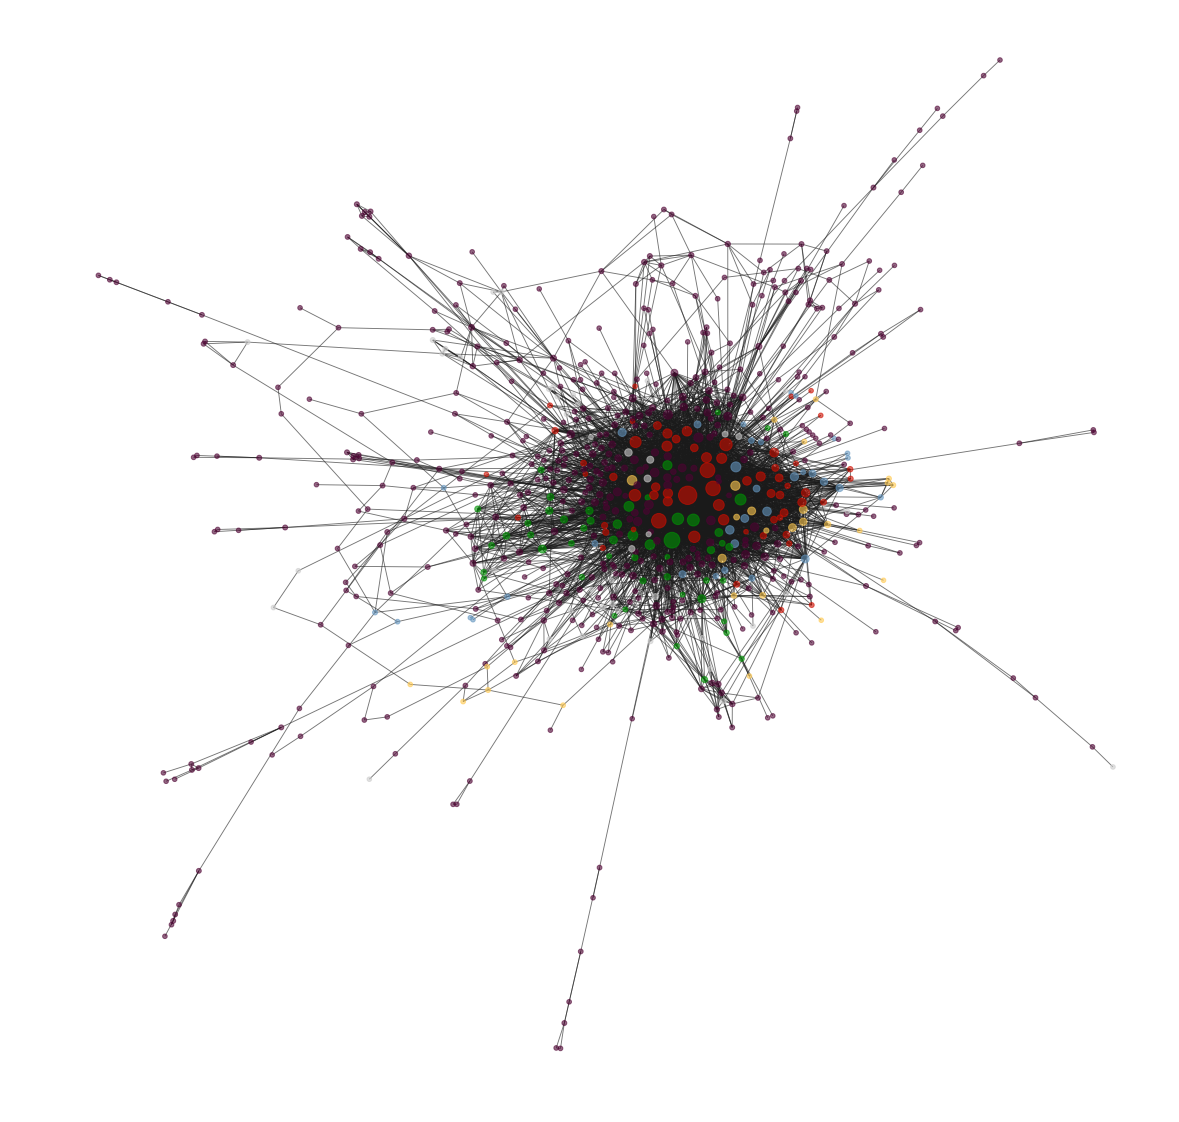

In [35]:
plt.figure(1, figsize=(20, 20))
nx.draw_networkx(
    relevant_characters,
    pos=position, 
    node_size=[20 + relevant_characters.degree(n) for n in relevant_characters.nodes],
    node_color=[generate_node_color(n, clean_character_dict) for n in relevant_characters.nodes],
    edge_color='.1', 
    with_labels=False, 
    width=0.9, 
    font_color ='#ff0000', 
    alpha=0.6)
plt.axis('off')
plt.show()

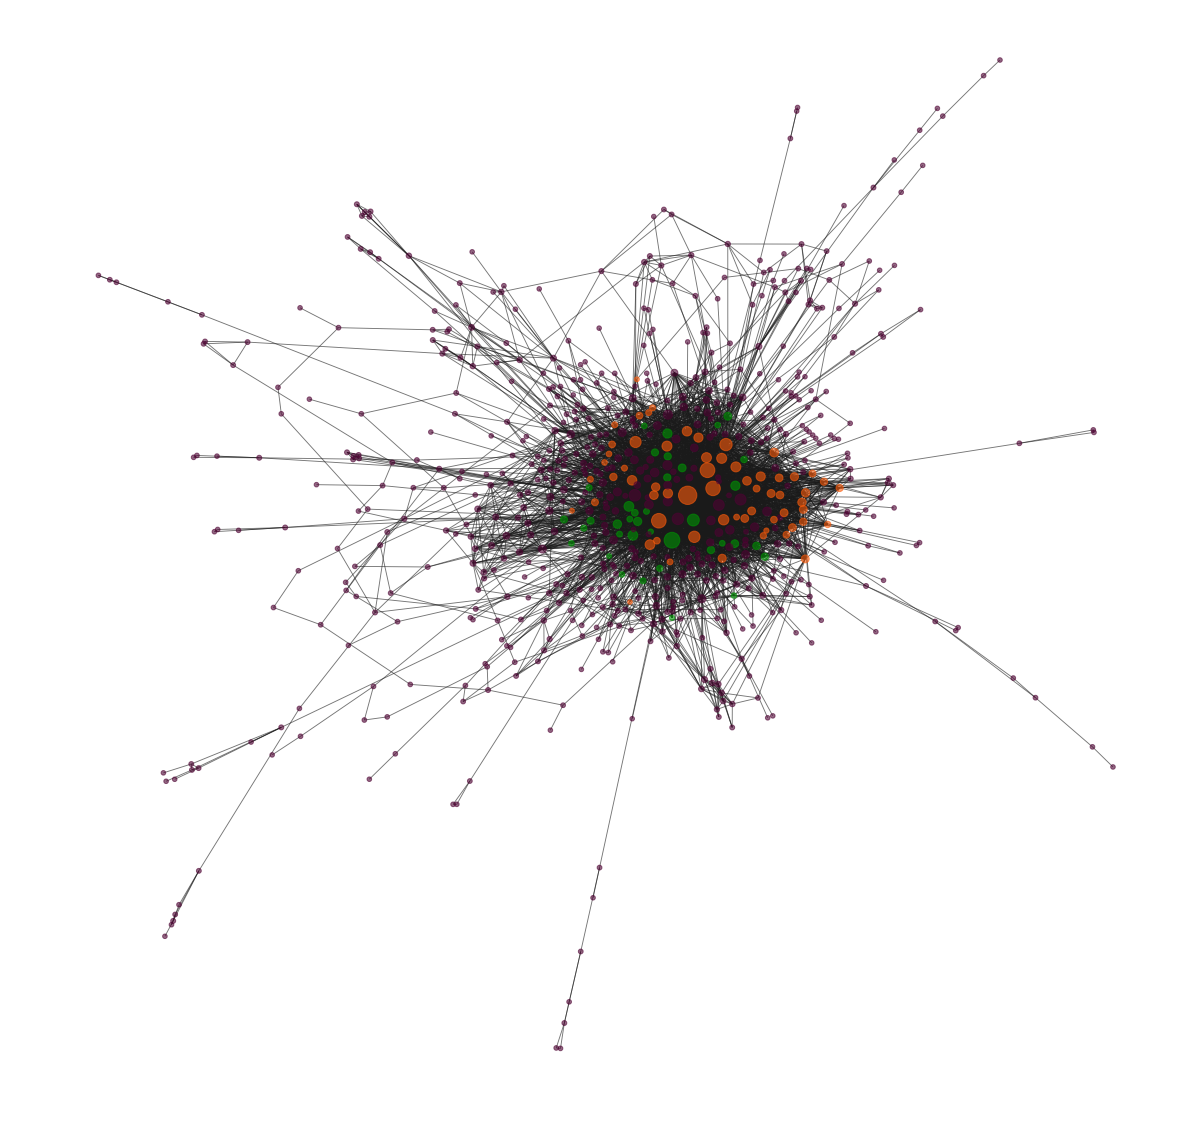

In [66]:
plt.figure(1, figsize=(20, 20))
nx.draw_networkx(
    relevant_characters,
    pos=position, 
    node_size=[20 + relevant_characters.degree(n) for n in relevant_characters.nodes],
    node_color=[generate_node_color2(n, clean_character_dict) for n in relevant_characters.nodes],
    edge_color='.1', 
    with_labels=False, 
    width=0.9, 
    font_color ='#ff0000', 
    alpha=0.6)
plt.axis('off')
plt.show()

In [29]:
sorted(relevant_characters.degree(), key=lambda kv: kv[1], reverse=True)

[(u'harry potter', 317),
 (u'tom riddle', 229),
 (u'ronald weasley', 198),
 (u'albus dumbledore', 194),
 (u'hermione granger', 191),
 (u'ginevra weasley', 133),
 (u'severus snape', 123),
 (u'sirius black', 116),
 (u'draco malfoy', 112),
 (u'rubeus hagrid', 110),
 (u'arthur weasley', 105),
 (u'dolores umbridge', 102),
 (u'neville longbottom', 98),
 (u'minerva mcgonagall', 89),
 (u'fred weasley', 82),
 (u'luna lovegood', 81),
 (u'molly weasley', 80),
 (u'george weasley', 79),
 (u'bellatrix lestrange', 77),
 (u'lucius malfoy', 76),
 (u'horace slughorn', 76),
 (u'nymphadora tonks', 72),
 (u'william weasley', 71),
 (u'remus lupin', 68),
 (u'cedric diggory', 66),
 (u'dean thomas', 65),
 (u'percy weasley', 65),
 (u'fleur delacour', 64),
 (u'peter pettigrew', 64),
 (u'rita skeeter', 63),
 (u'albus potter', 63),
 (u'angelina johnson', 58),
 (u'cornelius fudge', 56),
 (u'lee jordan', 55),
 (u'lily j. potter', 55),
 (u'kingsley shacklebolt', 54),
 (u'gilderoy lockhart', 54),
 (u'argus filch', 54)

In [112]:
def genrate_color_series(N):
    #4522
    np.random.seed(4569)
    colors = []
    for n in xrange(N):
        color = list(np.random.choice(range(256), size=3))
        colors.append('#%02x%02x%02x' % tuple(color))
    return colors

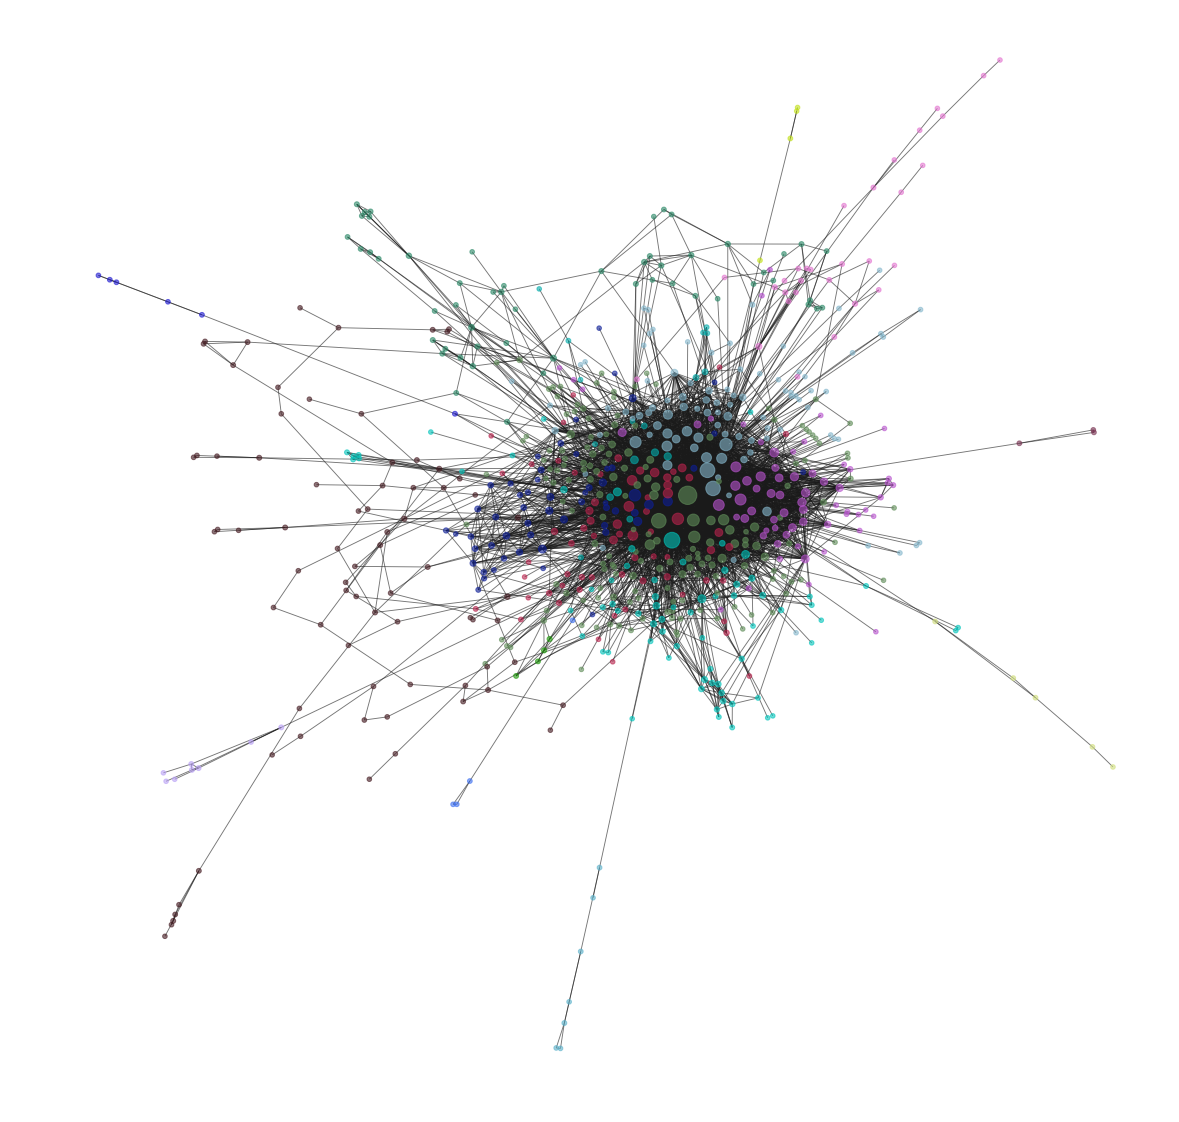

In [113]:
partitions = community.best_partition(relevant_characters,weight='weight')
unique_partitions = set(partitions.values())
partition_colors = dict(zip(unique_partitions, genrate_color_series(len(unique_partitions))))
color_map = [partition_colors[partitions[n]] for n in relevant_characters.nodes]

plt.figure(1, figsize=(20, 20))
nx.draw_networkx(
    relevant_characters,
    pos=position, 
    node_size=[20 + relevant_characters.degree(n) for n in relevant_characters.nodes],
    node_color=color_map,
    edge_color='.1', 
    with_labels=False, 
    width=0.9, 
    alpha=0.6
)
plt.axis('off')
plt.show()

In [133]:
grouped_by_community = defaultdict(list)

for character, community in partitions.iteritems():
    grouped_by_community[community].append((character,relevant_characters.degree(character)))

In [145]:
for community, characters in grouped_by_community.items()[:10]:
    print"------- community:", community, "-------"
    html = "<ul>"
    for character, degree in sorted(characters, key=itemgetter(1), reverse=True):
        print character, degree
        html += "<li>"+character+"</li>

------- community: 0 -------
dolores umbridge 102
neville longbottom 98
luna lovegood 81
cedric diggory 66
dean thomas 65
angelina johnson 58
lee jordan 55
seamus finnigan 51
katie bell 51
cho chang 48
garrick ollivander 45
parvati patil 44
terry boot 43
colin creevey 43
susan bones 43
hannah abbott 43
sybill trelawney 42
justin finch-fletchley 41
alicia spinnet 40
lavender brown 39
zacharias smith 35
michael corner 33
anthony goldstein 33
padma patil 29
oliver wood 28
xenophilius lovegood 28
marietta edgecombe 27
romilda vane 26
cormac mclaggen 25
firenze 23
leanne 21
dennis creevey 20
amelia bones 14
trevor 12
andrew kirke 10
oliver rivers 8
rolf scamander 7
bane 7
edgar bones 7
roger davies 6
tiberius 6
stephen cornfoot 6
roger malone 6
kevin entwhistle 6
magorian 5
summerby 4
gregory the smarmy 4
bertie higgs 4
pandora lovegood 4
wayne hopkins 3
harold dingle 3
orford umbridge 3
dolores umbridge's brother 3
ellen cracknell 3
binky 3
cassandra trelawney 3
romilda vane's grandmother 

thorsten pfeffer 2
connolly 2
gwendolyn morgan 2
gertie keddle 2
valmai morgan 2
glynnis griffiths 2
gwenog 2
timothy blenkinsop 2
felix summerbee 1
rudolf brand 1
raul almeida 1
barnabus blenkinsop 1
franziska faust 1
mullet 1
matilda dukelow 1
------- community: 6 -------
robert hilliard 9
lily moon 7
leonard spencer-moon 7
eldritch diggory 7
uric the oddball 5
gabriel truman 5
dennis moon 5
hesphaestus gore 5
evangeline orpington 5
goodwin kneen 5
josephina flint 4
bartholomew barebone 4
radolphus lestrange 4
glenda chittock 4
radulf 4
emily rappaport 4
perseus parkinson 4
lorcan mclaird 4
damocles rowle 4
loxias 4
arcus 3
phyllida spore 3
barnabas deverill 3
priscilla dupont 3
egbert the egregious 3
archer evermonde 3
artemisia lufkin 3
albert boot 3
dorcus twelvetrees 3
unctuous osbert 3
ottaline gambol 3
aristotle twelvetrees 3
hector fawley 3
basil flack 3
hengist of woodcroft 3
gunhilda kneen 3
ignatia wildsmith 3
bridget wenlock 3
livius 3
grogan stump 3
hengist of upper barnt